In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [2]:
pip install -U 'fastai>=2.0.0'


Note: you may need to restart the kernel to use updated packages.


In [3]:
pip install -Uqq fastbook

Note: you may need to restart the kernel to use updated packages.


In [6]:
from fastbook import *
from fastai.vision.widgets import *

In [42]:
key = os.environ.get('AZURE_SEARCH_KEY', '76122e4f7cf14f6797a0399b943bb709')

In [43]:
search_images_bing

<function fastbook.search_images_bing(key, term, min_sz=128, max_images=150)>

In [44]:
results = search_images_bing(key, 'grizzly bear')
ims = results.attrgot('contentUrl')
len(ims)

150

In [46]:
ims[0]

'https://tetonvalleylodge.com/wp-content/uploads/2015/04/grizzly-bear-idaho.jpg'

In [47]:
download_url

<function fastdownload.core.download_url(url, dest=None, timeout=None, show_progress=True)>

In [48]:
bear_types = 'grizzly','black','teddy'
path = Path('bears')

In [49]:
if not path.exists():
    path.mkdir()
    for o in bear_types:
        dest = (path/o)
        dest.mkdir(exist_ok=True)
        results = search_images_bing(key, f'{o} bear')
        download_images(dest, urls=results.attrgot('contentUrl'))

In [58]:
fns = get_image_files(path)
fns

(#435) [Path('bears/teddy/ed321b6d-6554-4655-868d-a86c340c756e.jpg'),Path('bears/teddy/10aedf06-7cec-4a32-bdfd-5fdbaa62d474.jpg'),Path('bears/teddy/45d74ffd-9ed0-4493-bbeb-0ebf8582ec42.jpg'),Path('bears/teddy/e62127e1-d0fe-4d83-8669-76279fa98d71.jpg'),Path('bears/teddy/0a550e95-64f0-4c20-a314-1223be667a38.jpg'),Path('bears/teddy/b588e6d7-55d9-4800-9a16-10ae9439196f.jpg'),Path('bears/teddy/5ec61b3c-f5b4-4733-95fc-40294b873c1e.jpg'),Path('bears/teddy/ecee797e-eed3-48c5-9f9e-32fceb0723ff.jpg'),Path('bears/teddy/cf4ed1bd-b5bf-4e86-8a11-da493686d9bd.jpg'),Path('bears/teddy/f8cdf003-a630-4fe8-915a-0c2ad25b06f6.jpg')...]

In [60]:
failed = verify_images(fns)
failed

(#4) [Path('bears/teddy/2afee018-4942-41ae-bc51-8758dfe62f2c.jpg'),Path('bears/grizzly/dc494271-a3b7-4308-afb0-346b984a49cc.jpg'),Path('bears/grizzly/fc2221c4-2aac-47ad-a750-01a7a2c45fc5.jpg'),Path('bears/grizzly/99749d60-5b79-4987-b56c-68ec9386d94d.jpg')]

In [61]:
failed.map(Path.unlink)

(#4) [None,None,None,None]

In [64]:
??get_image_files

Signature: get_image_files(path, recurse=True, folders=None)
Source:   
def get_image_files(path, recurse=True, folders=None):
    "Get image files in `path` recursively, only in `folders`, if specified."
    return get_files(path, extensions=image_extensions, recurse=recurse, folders=folders)
File:      /opt/conda/lib/python3.7/site-packages/fastai/data/transforms.py
Type:      function


In [63]:
bears = DataBlock(
    blocks=(ImageBlock, CategoryBlock), 
    get_items=get_image_files, 
    splitter=RandomSplitter(valid_pct=0.2, seed=42),
    get_y=parent_label,
    item_tfms=Resize(128))

In [65]:
dls = bears.dataloaders(path)

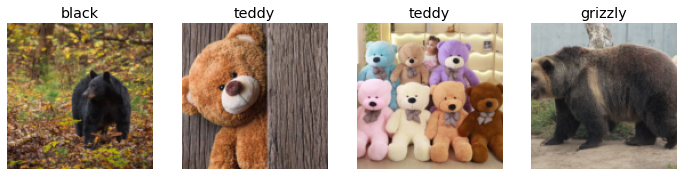

In [66]:
dls.valid.show_batch(max_n=4, nrows=1)

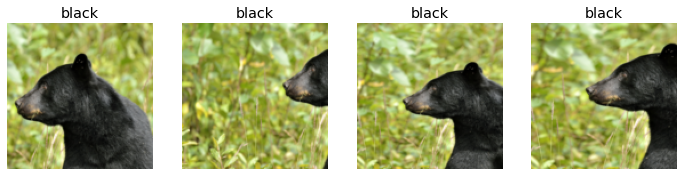

In [67]:
bears = bears.new(item_tfms=RandomResizedCrop(128, min_scale=0.3))
dls = bears.dataloaders(path)
dls.train.show_batch(max_n=4, nrows=1, unique=True)

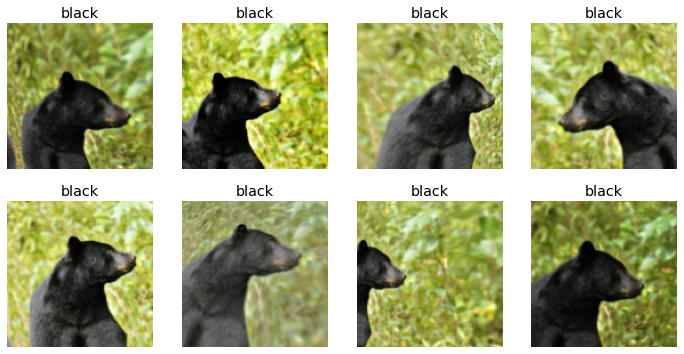

In [68]:
bears = bears.new(item_tfms=Resize(128), batch_tfms=aug_transforms(mult=2))
dls = bears.dataloaders(path)
dls.train.show_batch(max_n=8, nrows=2, unique=True)

In [69]:
bears = bears.new(
    item_tfms=RandomResizedCrop(224, min_scale=0.5),
    batch_tfms=aug_transforms())
dls = bears.dataloaders(path)

In [71]:
learn = vision_learner(dls, resnet18, metrics=error_rate)
learn.fine_tune(4)

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


  0%|          | 0.00/44.7M [00:00<?, ?B/s]

epoch,train_loss,valid_loss,error_rate,time
0,1.346170,0.075098,0.046512,01:21


epoch,train_loss,valid_loss,error_rate,time
0,0.177553,0.012199,0.000000,01:47
1,0.127045,0.002068,0.000000,01:46
2,0.095243,0.001302,0.000000,01:42
3,0.079195,0.001091,0.000000,01:44


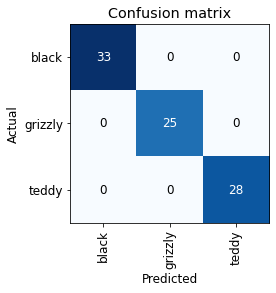

In [72]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix()

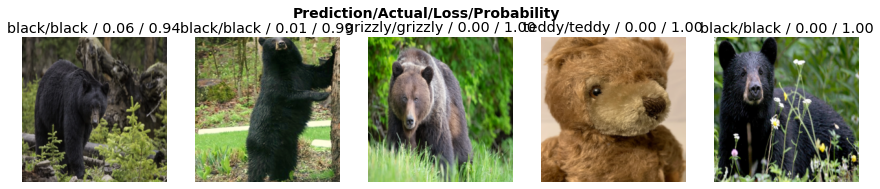

In [73]:
interp.plot_top_losses(5, nrows=1)

In [74]:
learn.export()

In [75]:
path = Path()
path.ls(file_exts='.pkl')

(#1) [Path('export.pkl')]

In [77]:
learn_inf = load_learner(path/'export.pkl')

In [85]:
results = search_images_bing(key, 'grizzly bear')
ims = results.attrgot('contentUrl')
len(ims)
dest = 'images/grizzly.jpg'
download_url(ims[0], dest)

Path('images/grizzly.jpg')

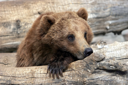

In [86]:
im = Image.open(dest)
im.to_thumb(128,128)

In [87]:
!ls

__notebook_source__.ipynb  bears  export.pkl  images


In [88]:
learn_inf.predict('images/grizzly.jpg')

('grizzly', TensorBase(1), TensorBase([1.4673e-06, 1.0000e+00, 2.7116e-06]))

In [92]:
btn_upload = widgets.FileUpload()
btn_upload

FileUpload(value={}, description='Upload')

In [94]:
img = PILImage.create(btn_upload.data[-1])

In [95]:
out_pl = widgets.Output()
out_pl.clear_output()
with out_pl: display(img.to_thumb(128,128))
out_pl

Output()

In [98]:
pred,pred_idx,probs = learn_inf.predict(img)

In [99]:
lbl_pred = widgets.Label()
lbl_pred.value = f'Prediction: {pred}; Probability: {probs[pred_idx]:.04f}'
lbl_pred

Label(value='Prediction: grizzly; Probability: 1.0000')

In [100]:
btn_run = widgets.Button(description='Classify')
btn_run

Button(description='Classify', style=ButtonStyle())

In [102]:
def on_click_classify(change):
    img = PILImage.create(btn_upload.data[-1])
    out_pl.clear_output()
    with out_pl: display(img.to_thumb(128,128))
    pred,pred_idx,probs = learn_inf.predict(img)
    lbl_pred.value = f'Prediction: {pred}; Probability: {probs[pred_idx]:.04f}'

btn_run.on_click(on_click_classify)

In [104]:
btn_upload = widgets.FileUpload()

In [106]:
Box([widgets.Label('Select your bear!'), 
      btn_upload, btn_run, out_pl, lbl_pred])

Box(children=(Label(value='Select your bear!'), FileUpload(value={}, description='Upload'), Button(description…

In [107]:
!pip install voila
!jupyter serverextension enable --sys-prefix voila

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.5/5.5 MB 11.8 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 89.9/89.9 kB 6.8 MB/s eta 0:00:00
  Attempting uninstall: jupyter-core
    Found existing installation: jupyter-core 4.10.0
    Uninstalling jupyter-core-4.10.0:
      Successfully uninstalled jupyter-core-4.10.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
beatrix-jupyterlab 3.1.7 requires google-cloud-bigquery-storage, which is not installed.
Enabling: voila
- Writing config: /opt/conda/etc/jupyter
    - Validating...
      voila 0.4.0 OK
